## FreqPulse-VAE: A Frequency-Conditioned Variational Autoencoder for Pulsatile Signal Generation

In [12]:
import os
import numpy as np
import pandas as pd
import yaml
from tqdm import trange, tqdm
from functools import reduce
from scipy import stats
import itertools

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.MainModel import *
from Models.Discriminator import FacDiscriminator
from Utilities.Utilities import *
from Utilities.EvaluationModules import *
from Models.Losses import *

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

def read_yaml(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

#### Env setting

In [10]:
ConfigName = 'FACFC_ART_50_800_RE'


if 'ART' in ConfigName:
    LoadConfig = 'Config' + 'ART'
elif 'PLETH' in ConfigName:
    LoadConfig = 'Config' + 'PLETH'
elif 'II' in ConfigName:
    LoadConfig = 'Config' + 'II'
else:
    assert False, "Please verify if the data type is properly included in the name of the configuration. The configuration name should be structured as 'Config' + 'data type', such as ConfigART."

yaml_path = './Config/'+LoadConfig+'.yml'

SavePath = './Results/'
ConfigSet = read_yaml(yaml_path)

### Model related parameters
SigType = ConfigSet[ConfigName]['SigType']
LatDim = ConfigSet[ConfigName]['LatDim']
CompSize = ConfigSet[ConfigName]['CompSize']
LossType = ConfigSet[ConfigName]['LossType']
    
MaskingRate = ConfigSet[ConfigName]['MaskingRate']
NoiseStd = ConfigSet[ConfigName]['NoiseStd']
MaskStd = ConfigSet[ConfigName]['MaskStd']
ReparaStd = ConfigSet[ConfigName]['ReparaStd']
FcLimit = ConfigSet[ConfigName]['FcLimit']
DecayH = ConfigSet[ConfigName]['DecayH']
DecayL = ConfigSet[ConfigName]['DecayL']
ReparaStd = 10
BatchSize = 10000

ModelName = ConfigName+'.hdf5'
### Model checkpoint
ModelSaveName = SavePath+ModelName


### Data

In [3]:
TrData = np.load('./Data/ProcessedData/Tr'+str(SigType)+'.npy')
ValData = np.load('./Data/ProcessedData/Val'+str(SigType)+'.npy')

SigDim = ValData.shape[1]
DataSize = ValData.shape[0]

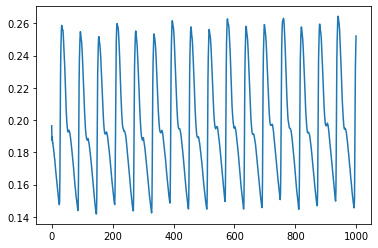

In [4]:
plt.plot(ValData[9])

### Post model

In [19]:
# Defining Modesl
EncModel = Encoder(SigDim=SigDim, LatDim= LatDim, Type = '', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = ReparaStd, Reparam=False, FcLimit=FcLimit)
FeatExtModel = FeatExtractor(SigDim=SigDim, CompSize = CompSize, DecayH=DecayH, DecayL=DecayL)
FeatGenModel = FeatGenerator(SigDim=SigDim,FeatDim=FeatExtModel.output[1].shape[-1], LatDim= LatDim)
ReconModel = Reconstructor(SigDim=SigDim, FeatDim=FeatExtModel.output[1].shape[-1])

Models = [EncModel,FeatExtModel,FeatGenModel,ReconModel] 

# Adding losses
if LossType =='TCLosses':
    Models = [EncModel,FeatExtModel,FeatGenModel,ReconModel] 
    SigRepModel = TCLosses(Models, DataSize, ConfigSet[ConfigName])

elif LossType =='FACLosses':
    DiscHiddenSize = ConfigSet[ConfigName]['DiscHiddenSize']
    FacDiscModel = FacDiscriminator(LatDim, DiscHiddenSize)
    Models = [EncModel,FeatExtModel,FeatGenModel,ReconModel, FacDiscModel] 
    SigRepModel = FACLosses(Models, ConfigSet[ConfigName])


### Load weights
SigRepModel.load_weights(ModelSaveName)

### Regularizer resetting
for i in SigRepModel.weights:
    if i.name.split('/')[0] in ['Beta_Z','Beta_Fc','Beta_TC', 'Beta_MI' ,'Beta_Orig', 'Beta_Feat']:
        i.assign(1.)
        
## Model Compile
SigRepModel.compile(optimizer='adam') 
SigRepModel.summary()

## The model for evaluation
RecOut = ReconModel(FeatGenModel.output)
GenModel = Model(FeatGenModel.input, RecOut)

OrigRecLoss added
FeatRecLoss added
kl_Loss_SKZ added
kl_Loss_TC added
kl_Loss_DTC added
kl_Loss_FC added
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp_Enc (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame_49 (TFOpLambda) (None, 20, 50)       0           Inp_Enc[0][0]                    
__________________________________________________________________________________________________
bidirectional_126 (Bidirectiona (None, 20, 50)       11550       tf.signal.frame_49[0][0]         
__________________________________________________________________________________________________
bidirectional_127 (Bidirectiona (None, 20, 50)       11550       bidirectional_126[0]

In [41]:
MaxFreq = 51
MinFreq = 1
NMiniBat = 100
SimSize = 3
MinFreqR=0.
MaxFreqR=0.05
NGen = 100
Ndata = len(ValData)
MASize = Ndata//NMiniBat
AnalData = ValData
NFCs = SigRepModel.get_layer('FCs').output.shape[-1]
NSelZ = 1
FCmuEps = 0.05

### The ratio of the max Power Spectral Density (PSD) value according to the given frequency.

(array([  185.,  4230.,  9098.,  8822.,  9638., 10768.,  9314.,  5947.,
         1863.,   135.]),
 array([0.16154048, 0.23948884, 0.31743719, 0.39538555, 0.47333391,
        0.55128227, 0.62923063, 0.70717898, 0.78512734, 0.8630757 ,
        0.94102406]),
 <BarContainer object of 10 artists>)

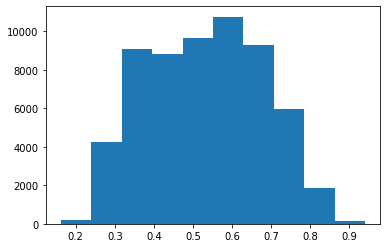

In [15]:
Data = ValData
HalfLen = Data.shape[-1]//2
FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen])[..., MinFreq:MaxFreq]
PSD = (FFTRes**2)/FFTRes.shape[-1]
PSD_Dist = np.max(PSD, axis=-1) / np.sum(PSD, axis=-1)
plt.hist(PSD_Dist, bins=10)

In [42]:
def FFT_PSE (Data, ReducedAxis, MinFreq = 1, MaxFreq = 51):
    # Dimension check; this part operates with 3D tensors.
    # (Batch_size, N_sample, N_frequency)
    Data = Data[:,None] if len(Data.shape) < 3 else Data

    # Power Spectral Density
    HalfLen = Data.shape[-1]//2
    FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen])[..., MinFreq:MaxFreq]
    # (Batch_size, N_sample, N_frequency)
    PSD = (FFTRes**2)/FFTRes.shape[-1]

    # Probability Density Function
    if ReducedAxis == 'All':
        AggPSD = np.mean(PSD, axis=(0,1))
        # (N_frequency,)
        AggPSEPDF = AggPSD / np.sum(AggPSD, axis=(-1),keepdims=True)
    
    elif ReducedAxis =='Batch':
        AggPSD = np.mean(PSD, axis=(1))
        # (Batch_size, N_frequency)
        AggPSEPDF = AggPSD / np.sum(AggPSD, axis=(-1),keepdims=True)
    
    elif ReducedAxis == 'None':
        # (Batch_size, N_sample, N_frequency)
        AggPSEPDF = PSD / np.sum(PSD, axis=(-1),keepdims=True)    
        
    return AggPSEPDF


def ProbPermutation(Data, Nframe=3, EpsProb = 1e-7):
    
    # Generate true permutation cases
    TruePerms = np.concatenate(list(itertools.permutations(np.arange(Nframe)))).reshape(-1, Nframe)

    # Get all permutation cases
    Data_Ext = tf.signal.frame(Data, frame_length=Nframe, frame_step=1, axis=-1)
    PermsTable =  np.argsort(Data_Ext, axis=-1)

    CountPerms = 1- (TruePerms[None,None,None] == PermsTable[:,:,:, None])
    CountPerms = 1-np.sum(CountPerms, axis=-1).astype('bool')
    CountPerms = np.sum(CountPerms, axis=(2))
    ProbCountPerms = CountPerms / np.sum(CountPerms, axis=-1, keepdims=True)
    
    return np.maximum(ProbCountPerms, EpsProb)    


def LocCandZs (FreqZs_Idx, Mode_Value, SumH, Samp_Z):
    
    for Freq, _ in FreqZs_Idx.items():
        Mode_Idx = np.where(Mode_Value == Freq)[0]

        # Skipping the remainder of the code if there are no mode values present at the predefined frequencies.
        if len(Mode_Idx) <1: 
            continue;

        # Calculating the minimum of sum of H (Min_SumH) and Candidate Z-values(CandZs)
        Min_SumH_Idx = np.argmin(SumH[Mode_Idx])
        Min_SumH = np.min(SumH[Mode_Idx])
        CandZs = Samp_Z[[Mode_Idx[Min_SumH_Idx]]][0].flatten()
        CandZ_Idx = np.where(CandZs!=0)[0]
        
        # Updating the Min_SumH value if the current iteration value is smaller.
        if Min_SumH < FreqZs_Idx[Freq][0]:
            FreqZs_Idx[Freq] = [Min_SumH, CandZ_Idx, CandZs[CandZ_Idx]]
    
    return FreqZs_Idx


def MeanKLD(P,Q):
    return np.mean(np.sum(P*np.log(P/Q), axis=-1))

def Sampler (Data):
    Zs_Out = SigRepModel.get_layer('Zs').output
    Sampler = Model(EncModel.input, Zs_Out)
    return Sampler.predict(Data, batch_size=BatchSize, verbose=1)   

In [20]:
P_PSE = FFT_PSE(AnalData, 'All')
Q_PSE_ZFc = FFT_PSE(SigGen_ZFc, 'Batch')
Q_PSE_ZjFc = FFT_PSE(SigGen_ZjFc, 'Batch')

Q_PSE_ZjFcRPT = FFT_PSE(SigGen_ZjFcRPT, 'Batch')
Q_PSE_ZjFcAr = FFT_PSE(SigGen_ZjFcAr, 'Batch')
Q_PSE_ZjFcMu = FFT_PSE(SigGen_ZjFcMu, 'Batch')

SubPSE_ZjFcRPT = FFT_PSE(SigGen_ZjFcRPT, 'None').transpose(0,2,1)
SubPSE_ZjFcMu = FFT_PSE(SigGen_ZjFcMu, 'None').transpose(0,2,1)
SubPSE_ZjFcAr = FFT_PSE(SigGen_ZjFcAr, 'None').transpose(0,2,1)

Q_FcPSE_ZjFcRPT = ProbPermutation(SubPSE_ZjFcRPT, Nframe=3, EpsProb = 1e-7)
Q_FcPSE_ZjFcMu = ProbPermutation(SubPSE_ZjFcMu, Nframe=3, EpsProb = 1e-7)
Q_FcPSE_ZjFcAr = ProbPermutation(SubPSE_ZjFcAr, Nframe=3, EpsProb = 1e-7)

I_zE_Z_ = MeanKLD(Q_PSE_ZFc, P_PSE[None] ) # I(zE;Z)
I_zE_ZjZ_ = MeanKLD(Q_PSE_ZjFc, Q_PSE_ZFc )  # I(zE;Zj|Z)
I_zE_ZjFm_ =  MeanKLD(Q_PSE_ZjFcMu, P_PSE[None] ) # I(zE;Zj)
I_zE_FaZj_ = MeanKLD(Q_PSE_ZjFcAr, Q_PSE_ZjFcMu ) # I(zE;FC|Zj)
I_fcE_FmZj_ = MeanKLD(Q_FcPSE_ZjFcMu, Q_FcPSE_ZjFcRPT) # I(fcE;Zj)
I_fcE_FaZj_ = MeanKLD(Q_FcPSE_ZjFcAr, Q_FcPSE_ZjFcMu) # I(fcE;FC|Zj)

# Locating the candidate Z values that generate good signals.
H_zE_ZjFa = -np.sum(Q_PSE_ZjFcAr * np.log(Q_PSE_ZjFcAr), axis=-1)
H_fcE_ZjFa = np.mean(-np.sum(Q_FcPSE_ZjFcAr * np.log(Q_FcPSE_ZjFcAr), axis=-1), axis=-1)
SumH_ZjFa = H_zE_ZjFa + H_fcE_ZjFa


# Calculating mode values of SigGen_ZjFcAr
Q_PSE_ZjFcAr_3D = FFT_PSE(SigGen_ZjFcAr, 'None')
# The 0 frequency is excluded as it represents the constant term; by adding 1 to the index, the frequency and index can be aligned to be the same.
Max_Value_Label = np.argmax(Q_PSE_ZjFcAr_3D, axis=-1) + 1
Mode_Value = stats.mode(Max_Value_Label.T, axis=0, keepdims=False)[0]
FreqZs_Idx = LocCandZs (FreqZs_Idx, Mode_Value, SumH_ZjFa, UniqSamp_Z)

NameError: name 'SigGen_ZFc' is not defined

6

In [ ]:
FC_Arange_ = np.tile(np.linspace(MinFreqR, MaxFreqR, NGen )[:, None], (1,NFCs))
 

### monte carlo approximation
I_zE_Z = 0
I_zE_ZjZ = 0
I_zE_ZjFm = 0
I_zE_FaZj = 0
I_fcE_FmZj = 0
I_fcE_FaZj = 0

FreqZs_Idx =  {i:[np.inf] for i in range(1, MaxFreq - MinFreq + 2)}

P_PSE = FFT_PSE(AnalData, 'All')

for sim in range(SimSize):
    
    SplitData = np.array_split(AnalData, MASize)
    with trange(MASize, leave=False) as t:
        
        for mini in range(MASize):
            
            '''
            ### Sampling Samp_Z and FCs and Reconstructing SigGen_ZFc ###
            
            - Shape of UniqSamp_Z: (NMiniBat, LatDim)
            - UniqSamp_Z ~ Q(z|y)
            
            - Samp_Z is a 3D tensor expanded by repeating the first axis (i.e., 0) of UniqSamp_Z by NGen times.
            - Shape of Samp_Z: (NMiniBat, NGen, LatDim) -> (NMiniBat*NGen, LatDim) for optimal use of GPU 
            - Shape of FCs: (NMiniBat, NGen, NFCs) -> (NMiniBat*NGen, LatDim) for optimal use of GPU 
            
            - SigGen_ZFc ~ Q(y | Samp_Z, FCs)*Q(Samp_Z | Y)*Q(FCs) 
            - UniqSamp_Z ~ Q(z|y), FCs ~ Bern(fc, μ=0.5)
            
            '''
            # Sampling Samp_Z 
            UniqSamp_Z = Sampler(SplitData[mini])
            Samp_Z =  np.broadcast_to(UniqSamp_Z[:, None], (NMiniBat, NGen, UniqSamp_Z.shape[-1])).reshape(-1, UniqSamp_Z.shape[-1])
            FCs = np.random.rand(NMiniBat *NGen, NFCs) * FcLimit
            
            
            '''
            ### Reconstructing SigGen_ZjFc ###
            
            - Masking is applied to select Samp_Zj from Samp_Z 
              by assuming that the Samp_Z with indices other than j have a fixed mean value of '0' following a Gaussian distribution.
              
            - Shape of Samp_Zj: (NMiniBat, NGen, LatDim) -> (NMiniBat*NGen, LatDim) for optimal use of GPU 
            - Shape of FCs: (NMiniBat, NGen, NFCs) -> (NMiniBat*NGen, LatDim) for optimal use of GPU 
            
            - SigGen_ZjFc ~ Q(y | Samp_Zj, FCs)*Q(Samp_Zj)*Q(j)*Q(FCs) 
            - Samp_Zj ~ Q(z|y), j∼U(1,LatDim), FCs ~ Bern(fc, μ=0.5)
            
            '''
            
            # Masking for selecting Samp_Zj from Samp_Z 
            Mask_Z = np.zeros((NMiniBat*NGen, LatDim))
            for i in range(NMiniBat*NGen):
                Mask_Z[i, np.random.choice(LatDim, NSelZ,replace=False )] = 1
            Samp_Zj = Samp_Z * Mask_Z
            
            
            '''
            ### Reconstructing SigGen_ZjFcRPT ###
            
            - Samp_ZjRPT is sampled from a Gaussian distribution with a mean of 0 and standard deviation; Samp_ZjRPT ~ N(0, ReparaStd)
              by assuming that the Samp_Z with indices other than j have a fixed mean value of '0', 
              then it's repeated NGen times along the second axis (i.e., 1).
              
            - Shape of Samp_ZjRPT: (NMiniBat, NGen, LatDim) -> (NMiniBat*NGen, LatDim) for optimal use of GPU 
            - Shape of FCs: (NMiniBat, NGen, NFCs) -> (NMiniBat*NGen, LatDim) for optimal use of GPU 
            
            - SigGen_ZjFcRPT ~ Q(y | Samp_ZjRPT, FCs)*Q(Samp_ZjRPT)*Q(j)*Q(FCs) 
            - Samp_ZjRPT ~ N(0, ReparaStd), j∼U(1,LatDim), FCs ~ Bern(fc, μ=0.5)
            
            '''
            
            # Selecting Samp_Zj from Guassian dist.
            Samp_ZjRPT = []
            for i in range(NMiniBat):
                Mask_Z = np.zeros((LatDim))
                # LatDim-wise Z sampling
                Mask_Z[ np.random.choice(LatDim, NSelZ,replace=False )]= np.random.normal(0, ReparaStd)
                # Setting the same Z value within the N generated signals (NGen).
                Samp_ZjRPT.append(np.broadcast_to(Mask_Z[None], (NGen,LatDim))[None]) 
            Samp_ZjRPT = np.concatenate(Samp_ZjRPT).reshape(NMiniBat *NGen, LatDim)
            
            
            '''
            ### Reconstructing SigGen_ZjFcAr ###
            
            - FC_Arange: The FC values are generated NGen times, based on the linspace with a fixed interval (0 ~ FcLimit).
              Thus, each sample(i.e., NMiniBat) has FC values that are sorted and generated by the linspace (i.e., NGen).
              
            - Shape of Samp_ZjRPT: (NMiniBat, NGen, LatDim) -> (NMiniBat*NGen, LatDim) for optimal use of GPU 
            - Shape of FC_Arange: (NMiniBat, NGen, NFCs) -> (NMiniBat*NGen, LatDim) for optimal use of GPU 
            
            - SigGen_ZjFcAr ~ Q(y | Samp_ZjRPT, FC_Arange)*Q(Samp_ZjRPT)*Q(j)*Q(FC_Arange)
            - Samp_ZjRPT ~ N(0, ReparaStd), j∼U(1,LatDim), FC_Arange∼U(0,FcLimit)
            
            '''

            # The FC values are generated NGen times, based on the linspace with a fixed interval.
            FC_Arange = np.broadcast_to(FC_Arange_[None], (NMiniBat, NGen, NFCs)).reshape(-1, NFCs)
            
            
            
            '''
            ### Reconstructing SigGen_ZjFcMu ###
            
            - Given that FC ~ (fc, μ=0.5), the expected value of FCmu should be 0.5 x FcLimit.
              This would result in all values within a single sample (NMiniBat, NGen) being equal.
              Thus, we assumed FC_Rand as FC_μ x FcLimit + eps, where FC_μ=0.5 and eps ~ N(0, 0.5*FcLimit*FCmuEps)
              
            - Shape of Samp_ZjRPT: (NMiniBat, NGen, LatDim) -> (NMiniBat*NGen, LatDim) for optimal use of GPU 
            - Shape of FC_Rand: (NMiniBat, NGen, NFCs) -> (NMiniBat*NGen, LatDim) for optimal use of GPU 
            
            - SigGen_ZjFcMu ~ Q(y | Samp_ZjRPT, FC_Rand)*Q(Samp_ZjRPT)*Q(j)*Q(FC_Arange)
            - Samp_ZjRPT ~ N(0, ReparaStd), j∼U(1,LatDim), FC_Arange∼U(0,FcLimit)
            
            '''
            
            # FC_Rand are sampled as FC_μ x FcLimit + eps, where FC_μ=0.5 and eps ~ N(0, 0.5*FcLimit*FCmuEps)
            FC_Rand = np.zeros_like(FCs) + FcLimit * 0.5 + np.random.normal(0, (FcLimit * 0.5)*FCmuEps, (FCs.shape))
            
            
            
            '''
            ### Signal reconstruction ###
            
            - To maximize the efficiency of GPU utilization, 
              we performed a binding operation on (NMiniBat, NGen, LatDim) for Zs and (NMiniBat, NGen, NFCs) for FCs, respectively, 
              transforming them to (NMiniBat * NGen, LatDim) and (NMiniBat * NGen, NFCs). 
              After the computation, we then reverted them back to their original dimensions.
              
            '''
            
            Set_FCs = np.concatenate([FCs,FCs,FCs,FC_Arange,FC_Rand])
            Set_Zs = np.concatenate([Samp_Z,Samp_Zj,Samp_ZjRPT,Samp_ZjRPT,Samp_ZjRPT])
            Set_Pred = GenModel.predict([Set_FCs[:, :2], Set_FCs[:, 2:], Set_Zs], batch_size=BatchSize, verbose=1).reshape(-1, NMiniBat, NGen, AnalData.shape[-1])
            SigGen_ZFc, SigGen_ZjFc, SigGen_ZjFcRPT, SigGen_ZjFcAr, SigGen_ZjFcMu = [np.squeeze(SubPred) for SubPred in np.split(Set_Pred, 5) ]  
            
            
            
            # Cumulative Power Spectral Entropy (PSE) over each frequency
            Q_PSE_ZFc = FFT_PSE(SigGen_ZFc, 'Batch')
            Q_PSE_ZjFc = FFT_PSE(SigGen_ZjFc, 'Batch')

            Q_PSE_ZjFcRPT = FFT_PSE(SigGen_ZjFcRPT, 'Batch')
            Q_PSE_ZjFcAr = FFT_PSE(SigGen_ZjFcAr, 'Batch')
            Q_PSE_ZjFcMu = FFT_PSE(SigGen_ZjFcMu, 'Batch')

            SubPSE_ZjFcRPT = FFT_PSE(SigGen_ZjFcRPT, 'None').transpose(0,2,1)
            SubPSE_ZjFcMu = FFT_PSE(SigGen_ZjFcMu, 'None').transpose(0,2,1)
            SubPSE_ZjFcAr = FFT_PSE(SigGen_ZjFcAr, 'None').transpose(0,2,1)

            
            # Permutation Entropy given PSE over each generation
            Q_FcPSE_ZjFcRPT = ProbPermutation(SubPSE_ZjFcRPT, Nframe=3, EpsProb = 1e-7)
            Q_FcPSE_ZjFcMu = ProbPermutation(SubPSE_ZjFcMu, Nframe=3, EpsProb = 1e-7)
            Q_FcPSE_ZjFcAr = ProbPermutation(SubPSE_ZjFcAr, Nframe=3, EpsProb = 1e-7)

            
            # Conditional mutual information
            I_zE_Z_ = MeanKLD(Q_PSE_ZFc, P_PSE[None] ) # I(zE;Z)
            I_zE_ZjZ_ = MeanKLD(Q_PSE_ZjFc, Q_PSE_ZFc )  # I(zE;Zj|Z)
            I_zE_ZjFm_ =  MeanKLD(Q_PSE_ZjFcMu, P_PSE[None] ) # I(zE;Zj)
            I_zE_FaZj_ = MeanKLD(Q_PSE_ZjFcAr, Q_PSE_ZjFcMu ) # I(zE;FC|Zj)
            I_fcE_FmZj_ = MeanKLD(Q_FcPSE_ZjFcMu, Q_FcPSE_ZjFcRPT) # I(fcE;Zj)
            I_fcE_FaZj_ = MeanKLD(Q_FcPSE_ZjFcAr, Q_FcPSE_ZjFcMu) # I(fcE;FC|Zj)
            
            
            print('I_zE_Z :', I_zE_Z_)
            I_zE_Z += I_zE_Z_
            
            print('I_zE_ZjZ :', I_zE_ZjZ_)
            I_zE_ZjZ += I_zE_ZjZ_
            
            print('I_zE_ZjFm :', I_zE_ZjFm_)
            I_zE_ZjFm += I_zE_ZjFm_
            
            print('I_zE_FaZj :', I_zE_FaZj_)
            I_zE_FaZj += I_zE_FaZj_
            
            print('I_fcE_FmZj :', I_fcE_FmZj_)
            I_fcE_FmZj += I_fcE_FmZj_
            
            print('I_fcE_FaZj :', I_fcE_FaZj_)
            I_fcE_FaZj += I_fcE_FaZj_

            
            # Locating the candidate Z values that generate good signals.
            H_zE_ZjFa = -np.sum(Q_PSE_ZjFcAr * np.log(Q_PSE_ZjFcAr), axis=-1)
            H_fcE_ZjFa = np.mean(-np.sum(Q_FcPSE_ZjFcAr * np.log(Q_FcPSE_ZjFcAr), axis=-1), axis=-1)
            SumH_ZjFa = H_zE_ZjFa + H_fcE_ZjFa


            # Calculating mode values of SigGen_ZjFcAr
            Q_PSE_ZjFcAr_3D = FFT_PSE(SigGen_ZjFcAr, 'None')
            # The 0 frequency is excluded as it represents the constant term; by adding 1 to the index, the frequency and index can be aligned to be the same.
            Max_Value_Label = np.argmax(Q_PSE_ZjFcAr_3D, axis=-1) + 1
            Mode_Value = stats.mode(Max_Value_Label.T, axis=0, keepdims=False)[0]
            UniqSamp_ZjRPT = Samp_ZjRPT.reshape(NMiniBat, NGen, -1)[:, 0]
            FreqZs_Idx = LocCandZs (FreqZs_Idx, Mode_Value, SumH_ZjFa, UniqSamp_ZjRPT)
            
            t.update(1)
            
# CMI(V;Zj, Z)
I_zE_Z /= (MASize*SimSize)
I_zE_ZjZ /= (MASize*SimSize)
CMI_zE_ZjZ = I_zE_Z + I_zE_ZjZ             

# CMI(V;FC,Zj)
I_zE_ZjFm /= (MASize*SimSize)
I_zE_FaZj /= (MASize*SimSize)
CMI_zE_FcZj = I_zE_ZjFm + I_zE_FaZj             

# CMI(VE;FA,FM)
I_fcE_FmZj /= (MASize*SimSize)
I_fcE_FaZj /= (MASize*SimSize)
CMI_fcE_FaFm = I_fcE_FmZj + I_fcE_FaZj    

  0%|                                                                                          | 0/600 [00:00<?, ?it/s]

5/5 [==============================] - 1s 174ms/step


  0%|▏                                                                                 | 1/600 [00:04<44:38,  4.47s/it]

I_zE_Z : 1.7170697237820178
I_zE_ZjZ : 3.738148537660771
I_zE_ZjFm : 1.794026022676342
I_zE_FaZj : 0.2524305632994648
I_fcE_FmZj : 0.035669718020756636
I_fcE_FaZj : 0.6275369424641228
5/5 [==============================] - 1s 179ms/step


  0%|▎                                                                                 | 2/600 [00:10<51:37,  5.18s/it]

I_zE_Z : 1.783031800056041
I_zE_ZjZ : 3.8692789079490604
I_zE_ZjFm : 1.8147595027258638
I_zE_FaZj : 0.31207510623507795
I_fcE_FmZj : 0.03602370779550346
I_fcE_FaZj : 0.62069479263672
5/5 [==============================] - 1s 130ms/step


  0%|▍                                                                                 | 3/600 [00:14<47:22,  4.76s/it]

I_zE_Z : 1.6977949539336645
I_zE_ZjZ : 3.7282695239228336
I_zE_ZjFm : 1.7227567386511469
I_zE_FaZj : 0.2529731701858079
I_fcE_FmZj : 0.03654594818154548
I_fcE_FaZj : 0.6100553501125873
5/5 [==============================] - 1s 146ms/step


  1%|▌                                                                                 | 4/600 [00:18<45:43,  4.60s/it]

I_zE_Z : 1.7050300381862615
I_zE_ZjZ : 3.71444738383221
I_zE_ZjFm : 1.8640206062143592
I_zE_FaZj : 0.34514624841642166
I_fcE_FmZj : 0.035738568514375416
I_fcE_FaZj : 0.6049847229880893
5/5 [==============================] - 1s 167ms/step


  1%|▋                                                                                 | 5/600 [00:23<45:01,  4.54s/it]

I_zE_Z : 1.7910272876516664
I_zE_ZjZ : 3.9410785908112285
I_zE_ZjFm : 1.8898421136522126
I_zE_FaZj : 0.20725846677659107
I_fcE_FmZj : 0.03639873184783983
I_fcE_FaZj : 0.645951851174184
5/5 [==============================] - 1s 168ms/step


  1%|▊                                                                                 | 6/600 [00:28<48:48,  4.93s/it]

I_zE_Z : 1.7139115962086098
I_zE_ZjZ : 3.81535983751901
I_zE_ZjFm : 1.8958921801821764
I_zE_FaZj : 0.2952662745131853
I_fcE_FmZj : 0.03657537058189229
I_fcE_FaZj : 0.6287820871488169
5/5 [==============================] - 1s 154ms/step


  1%|▉                                                                                 | 7/600 [00:33<46:48,  4.74s/it]

I_zE_Z : 1.702334781354537
I_zE_ZjZ : 4.031664713158067
I_zE_ZjFm : 1.8612690975859254
I_zE_FaZj : 0.3010043583965722
I_fcE_FmZj : 0.03703711507837436
I_fcE_FaZj : 0.6315327412698891
5/5 [==============================] - 1s 169ms/step


  1%|█                                                                                 | 8/600 [00:37<45:30,  4.61s/it]

I_zE_Z : 1.7383327496452028
I_zE_ZjZ : 3.580354771839032
I_zE_ZjFm : 1.6968743753278037
I_zE_FaZj : 0.23737547136773698
I_fcE_FmZj : 0.03659453086423797
I_fcE_FaZj : 0.6067425384401371
5/5 [==============================] - 1s 140ms/step


  2%|█▏                                                                                | 9/600 [00:41<44:26,  4.51s/it]

I_zE_Z : 1.8519811443524477
I_zE_ZjZ : 3.6947618104481297
I_zE_ZjFm : 1.7999228158731926
I_zE_FaZj : 0.2261809741070158
I_fcE_FmZj : 0.03610086442457053
I_fcE_FaZj : 0.6099184650531472
5/5 [==============================] - 1s 166ms/step


  2%|█▎                                                                               | 10/600 [00:47<48:12,  4.90s/it]

I_zE_Z : 1.832938206801453
I_zE_ZjZ : 3.7058745673964513
I_zE_ZjFm : 1.811758224837421
I_zE_FaZj : 0.2541608836141985
I_fcE_FmZj : 0.03739902366681993
I_fcE_FaZj : 0.6252675739925153
5/5 [==============================] - 1s 155ms/step


  2%|█▍                                                                               | 11/600 [00:51<46:21,  4.72s/it]

I_zE_Z : 1.723903710103604
I_zE_ZjZ : 3.7071684265572213
I_zE_ZjFm : 1.763456403555636
I_zE_FaZj : 0.15154297689694032
I_fcE_FmZj : 0.03527856699204895
I_fcE_FaZj : 0.6280855388238867
5/5 [==============================] - 1s 141ms/step


  2%|█▌                                                                               | 12/600 [00:56<45:06,  4.60s/it]

I_zE_Z : 1.8087263159470985
I_zE_ZjZ : 3.7933059326511813
I_zE_ZjFm : 1.7787578828070592
I_zE_FaZj : 0.33800539571088484
I_fcE_FmZj : 0.037159554464455076
I_fcE_FaZj : 0.6147338709469797
5/5 [==============================] - 1s 152ms/step


  2%|█▊                                                                               | 13/600 [01:00<44:28,  4.55s/it]

I_zE_Z : 1.6650738185117597
I_zE_ZjZ : 3.6158334238153276
I_zE_ZjFm : 1.6980167690525874
I_zE_FaZj : 0.21301680145058433
I_fcE_FmZj : 0.03634217342871908
I_fcE_FaZj : 0.6159398360442083
5/5 [==============================] - 1s 156ms/step


  2%|█▉                                                                               | 14/600 [01:06<47:49,  4.90s/it]

I_zE_Z : 1.7311802230758624
I_zE_ZjZ : 3.621651137925263
I_zE_ZjFm : 1.8283230381593725
I_zE_FaZj : 0.268448612873185
I_fcE_FmZj : 0.03658509475865423
I_fcE_FaZj : 0.6218646724211181
5/5 [==============================] - 1s 148ms/step


  2%|██                                                                               | 15/600 [01:10<45:58,  4.72s/it]

I_zE_Z : 1.7427491786397689
I_zE_ZjZ : 3.793478178289021
I_zE_ZjFm : 1.778034616722306
I_zE_FaZj : 0.2813637586971673
I_fcE_FmZj : 0.035976349178230456
I_fcE_FaZj : 0.6146400118399777
5/5 [==============================] - 1s 185ms/step


  3%|██▏                                                                              | 16/600 [01:15<45:20,  4.66s/it]

I_zE_Z : 1.771541352292177
I_zE_ZjZ : 3.846544053709351
I_zE_ZjFm : 1.7678776946831067
I_zE_FaZj : 0.20868860408632878
I_fcE_FmZj : 0.03583486347936661
I_fcE_FaZj : 0.6195581316926254
5/5 [==============================] - 1s 156ms/step


  3%|██▎                                                                              | 17/600 [01:19<44:17,  4.56s/it]

I_zE_Z : 1.650616508556172
I_zE_ZjZ : 3.8625292280193317
I_zE_ZjFm : 1.7488816170477761
I_zE_FaZj : 0.21785569270253977
I_fcE_FmZj : 0.03626306430819193
I_fcE_FaZj : 0.6111815609907044
5/5 [==============================] - 1s 180ms/step


  3%|██▍                                                                              | 18/600 [01:25<47:42,  4.92s/it]

I_zE_Z : 1.7252882580319888
I_zE_ZjZ : 4.051837400860569
I_zE_ZjFm : 1.7385514563132736
I_zE_FaZj : 0.2490388527838712
I_fcE_FmZj : 0.036938360992543585
I_fcE_FaZj : 0.604265661080095
5/5 [==============================] - 1s 150ms/step


  3%|██▌                                                                              | 19/600 [01:29<45:54,  4.74s/it]

I_zE_Z : 1.750922742183927
I_zE_ZjZ : 3.7993252417480226
I_zE_ZjFm : 1.7211069496050664
I_zE_FaZj : 0.15932305029941216
I_fcE_FmZj : 0.0366330752020997
I_fcE_FaZj : 0.6384427629240988
5/5 [==============================] - 1s 180ms/step


  3%|██▋                                                                              | 20/600 [01:34<45:06,  4.67s/it]

I_zE_Z : 1.7251281646749785
I_zE_ZjZ : 3.721000494550198
I_zE_ZjFm : 1.7912707994141643
I_zE_FaZj : 0.24098005738276954
I_fcE_FmZj : 0.036017633937551065
I_fcE_FaZj : 0.6231347658431448
5/5 [==============================] - 1s 148ms/step


  4%|██▊                                                                              | 21/600 [01:38<43:48,  4.54s/it]

I_zE_Z : 1.7093136579899302
I_zE_ZjZ : 3.8707561223207483
I_zE_ZjFm : 1.8058246701164211
I_zE_FaZj : 0.1778475801281515
I_fcE_FmZj : 0.03594188857370822
I_fcE_FaZj : 0.6219656331429906
5/5 [==============================] - 1s 170ms/step


  4%|██▉                                                                              | 22/600 [01:44<47:22,  4.92s/it]

I_zE_Z : 1.734005315093734
I_zE_ZjZ : 3.830459383843967
I_zE_ZjFm : 1.740675840456767
I_zE_FaZj : 0.17978617943407982
I_fcE_FmZj : 0.03706253767487101
I_fcE_FaZj : 0.6292681991740148
5/5 [==============================] - 1s 140ms/step


  4%|███                                                                              | 23/600 [01:48<45:40,  4.75s/it]

I_zE_Z : 1.6626273774155058
I_zE_ZjZ : 3.6417588030622365
I_zE_ZjFm : 1.7365060410920936
I_zE_FaZj : 0.18682600685983053
I_fcE_FmZj : 0.0351509413337674
I_fcE_FaZj : 0.6209685434851774
5/5 [==============================] - 1s 166ms/step


  4%|███▏                                                                             | 24/600 [01:52<44:35,  4.65s/it]

I_zE_Z : 1.8148472638665618
I_zE_ZjZ : 4.357615322211343
I_zE_ZjFm : 1.8081592706123928
I_zE_FaZj : 0.20508913584865904
I_fcE_FmZj : 0.035523723098547226
I_fcE_FaZj : 0.6256235216283518
5/5 [==============================] - 1s 142ms/step


  4%|███▍                                                                             | 25/600 [01:57<43:28,  4.54s/it]

I_zE_Z : 1.865585159191835
I_zE_ZjZ : 4.052272819917339
I_zE_ZjFm : 1.7407198687410033
I_zE_FaZj : 0.21550555716123734
I_fcE_FmZj : 0.03570924166558805
I_fcE_FaZj : 0.6343340670222658
5/5 [==============================] - 1s 165ms/step


  4%|███▌                                                                             | 26/600 [02:02<46:44,  4.89s/it]

I_zE_Z : 1.707985717920119
I_zE_ZjZ : 3.563465913733414
I_zE_ZjFm : 1.888252411614265
I_zE_FaZj : 0.2933101184682601
I_fcE_FmZj : 0.03482603974974459
I_fcE_FaZj : 0.6402108432106852
5/5 [==============================] - 1s 151ms/step


  4%|███▋                                                                             | 27/600 [02:07<45:05,  4.72s/it]

I_zE_Z : 1.72633010825716
I_zE_ZjZ : 3.7972154586535227
I_zE_ZjFm : 1.8474567870112952
I_zE_FaZj : 0.2258651014161641
I_fcE_FmZj : 0.036553872236896906
I_fcE_FaZj : 0.6094867977875036
5/5 [==============================] - 1s 176ms/step


  5%|███▊                                                                             | 28/600 [02:11<44:28,  4.66s/it]

I_zE_Z : 1.7893514323116413
I_zE_ZjZ : 3.6912348524626095
I_zE_ZjFm : 1.8718410344305847
I_zE_FaZj : 0.15479102557980967
I_fcE_FmZj : 0.035950105443594754
I_fcE_FaZj : 0.6291300550656294


In [38]:
SumH = SumH_ZjFa

In [40]:
SumH.shape

(500,)

In [22]:
FreqZs_Idx

{1: [2.6540334251612574, array([27], dtype=int64), array([26.42937709])],
 2: [inf],
 3: [inf],
 4: [inf],
 5: [inf],
 6: [inf],
 7: [3.700609132933205, array([2], dtype=int64), array([-12.28420246])],
 8: [2.1169339126078244, array([29], dtype=int64), array([7.29770844])],
 9: [1.9017786340434872, array([7], dtype=int64), array([-10.54108726])],
 10: [1.5959689830123147, array([9], dtype=int64), array([6.97205264])],
 11: [1.8849801364637846, array([21], dtype=int64), array([-39.42704718])],
 12: [1.36670174862103, array([40], dtype=int64), array([-5.98219121])],
 13: [1.3353831411500683, array([12], dtype=int64), array([8.04467139])],
 14: [1.4000969251070086, array([42], dtype=int64), array([-3.08716926])],
 15: [1.6263442564410129, array([28], dtype=int64), array([3.74199234])],
 16: [1.4289458843917786, array([11], dtype=int64), array([7.29111991])],
 17: [1.6048480372953562, array([18], dtype=int64), array([-2.58283733])],
 18: [1.6943856489770623, array([5], dtype=int64), array(

In [36]:
FreqInt = 9
FreqZs_Idx[FreqInt]

[1.9017786340434872, array([7], dtype=int64), array([-10.54108726])]

In [37]:
Ztmp = np.zeros((1,50))
Ztmp[:, FreqZs_Idx[FreqInt][1][0]] = FreqZs_Idx[FreqInt][2][0]
Ztmp = np.broadcast_to(Ztmp, (100, 50))
ZtmpPred = GenModel.predict([FC_Arange[:100, :2], FC_Arange[:100, 2:], Ztmp], batch_size=BatchSize, verbose=1)

Data = ZtmpPred
HalfLen = Data.shape[-1]//2
FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen])[..., MinFreq:MaxFreq]
PSD = (FFTRes**2)/FFTRes.shape[-1]

1/1 [==============================] - 0s 103ms/step


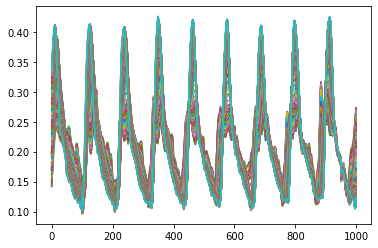

In [38]:
for i in range(100):
    plt.plot(ZtmpPred[i])

([<matplotlib.axis.XTick at 0x15902c35220>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

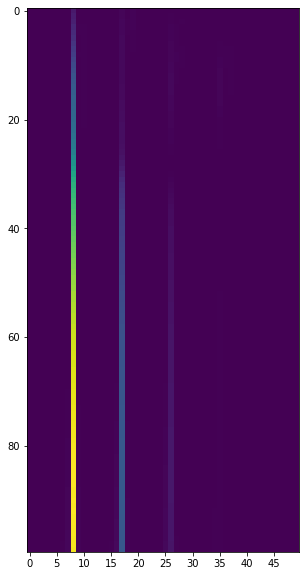

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(PSD)
plt.xticks(np.arange(0, 50, 5))


In [40]:
np.argmax(np.sum(PSD, axis=0))

8